In [0]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

--2018-11-05 15:41:56--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip [following]
--2018-11-05 15:41:57--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X2.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 925390592 (883M) [application/zip]
Saving to: ‘DIV2K_train_LR_bicubic_X2.zip’

DIV2K_train_LR_bicu 100%[===================>] 882.52M  8.17MB/s    in 2m 4s   

2018-11-05 15:44:02 (7.14 MB/s) - ‘DIV2K_train_LR_bicubic_X2.zip’ saved [925390592/925390592]

--2018-11-05 15:44:04--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resol

In [0]:
ls

DIV2K_train_HR/          DIV2K_train_LR_bicubic_X2.zip  sample_data/
DIV2K_train_HR.zip       memory_saving_gradients.py
DIV2K_train_LR_bicubic/  __pycache__/


In [0]:
!curl https://raw.githubusercontent.com/openai/gradient-checkpointing/master/memory_saving_gradients.py -o memory_saving_gradients.py
!pip install -U toposort networkx pytest

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17369  100 17369    0     0  43640      0 --:--:-- --:--:-- --:--:-- 43640
Requirement already up-to-date: networkx in /usr/local/lib/python3.6/dist-packages (2.2)
    100% |████████████████████████████████| 225kB 7.0MB/s 
    100% |████████████████████████████████| 51kB 18.1MB/s 


In [0]:
!unzip DIV2K_train_HR.zip 1>/dev/null
!unzip DIV2K_train_LR_bicubic_X2.zip 1>/dev/null

In [0]:
import os
len(os.listdir("DIV2K_train_LR_bicubic/X2/"))

800

In [0]:
import random
import glob
import tqdm
import tensorflow as tf
import memory_saving_gradients
tf.__dict__["gradients"] = memory_saving_gradients.gradients_memory
import os
def preprocess(LR,HR,lr_tag,lr_image_size,hr_image_size,batch_size = 32):
  try:  
    epoch = 1
    bn = 1
    Hr = glob.glob(HR+"/*.png")
    while True:
      print("EPOCH: %d"%epoch)
      random.shuffle(Hr)
      hr_list = []
      lr_list = []
      #l = hr
      for i in range(1,len(Hr)+1):
        hr = tf.image.decode_image(tf.read_file(Hr[i]),channels = 3)
        hr = tf.image.resize_image_with_crop_or_pad(hr,hr_image_size,hr_image_size)
        lr = tf.image.decode_image(tf.read_file(LR+os.path.basename("".join(Hr[i].split(".")[:-1])+lr_tag+".png")),channels = 3)
        lr = tf.image.resize_image_with_crop_or_pad(lr,lr_image_size,lr_image_size)
        hr.set_shape((hr_image_size,hr_image_size,3))
        lr.set_shape((lr_image_size,lr_image_size,3))
        hr_list.append(hr)
        lr_list.append(lr)
        if not i%batch_size:
          hr_batch = tf.stack(hr_list,name = "batch/high-res")
          lr_batch = tf.stack(lr_list,name = "batch/low-res")
          print("BATCH: %d"%bn)
          bn+=1
          yield hr_batch,lr_batch,epoch
          hr_list = []
          lr_list = []
      epoch += 1
  except Exception as e:
    print(str(e))

In [0]:
high_res = "DIV2K_train_HR/"
low_res = "DIV2K_train_LR_bicubic/X2/"
gen = preprocess(low_res,high_res,"x2",256,1024) # High Res Batch, Low Res Batch, Epoch

In [0]:
images = next(gen)

EPOCH: 1
BATCH: 1


In [0]:
print(images)

(<tf.Tensor 'batch/high-res:0' shape=(32, 1024, 1024, 3) dtype=uint8>, <tf.Tensor 'batch/low-res:0' shape=(32, 256, 256, 3) dtype=uint8>, 1)


(1024, 1024, 3) (256, 256, 3)


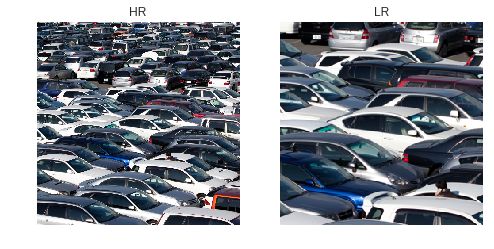

In [0]:
with tf.Session() as sess:
  hr,lr = sess.run([images[0],images[1]])
  print(hr[0].shape,lr[0].shape)
  plt.subplot(121)
  plt.axis("off")
  plt.title("HR")
  plt.imshow(hr[0])
  plt.subplot(122)
  plt.axis("off")
  plt.title("LR")
  plt.imshow(lr[0])

In [0]:
from functools import reduce
def weights(shape):
    return tf.Variable(tf.random_normal(shape))
def biases(shape):
    return tf.Variable(tf.random_normal([shape]))
def flatten(input_):
  #s = reduce(lambda x,y:x*y,list(map(input_.shape[1:],int)))
  return tf.reshape(input_,[-1,input_.shape[1:].num_elements()])
def dense(input_,out):
  w = weights([int(input_.shape[-1]),out])
  b = biases(out)
  return tf.matmul(input_,w)+b
def conv2d(input_,filter_size,outchannel,activate = False, normalize = False,strides = [1,1,1,1]):
    inchannel = int(input_.shape[-1])
    filter_ = weights([filter_size,filter_size,inchannel,outchannel])
    conv = tf.nn.conv2d(input_,filter_,padding = "SAME",strides = strides)
    bias = biases(outchannel)
    out = conv+bias
    if normalize:
        out = tf.layers.batch_normalization(out)
    if activate:
        out = tf.contrib.keras.layers.PReLU(shared_axes = [1,2])(out)
    return out
def generator_model(input_,high_res_):
    vgg19 = tf.keras.applications.VGG19(include_top = False, weights = "imagenet")
    for layer in vgg19.layers:
      layer.trainable = False
    x = conv2d(input_,9,64,activate = True)
    h = x
    with tf.name_scope("Residual_Blocks"):
      for i in range(5):
          h1 = conv2d(h,3,64,activate = True,normalize = True)
          h2 = conv2d(h1,3,64,normalize = True)
          h = h + h2
    with tf.name_scope("final_element_wise_add"):
      h = conv2d(input_,3,64,normalize = True)
      h = h + x
    with tf.name_scope("pixel_shuffle_layers"):
      for i in range(2):
        h = conv2d(h,3,256)
        h = tf.depth_to_space(h,2)
        h = tf.contrib.keras.layers.PReLU(shared_axes = [1,2])(h)
    with tf.name_scope("final_conv"):
      out = conv2d(h,9,3)
    v_pred = vgg19(out)
    v_true = vgg19(high_res_)
    loss = tf.reduce_mean(tf.square(v_true-v_pred))
    # Noise Reduction Loss / Experimental
    #loss = 0.006*tf.reduce_mean(tf.square(v_true - v_pred)) + 2e-8*tf.reduce_mean(tf.image_varition(v_pred))
    return out,loss
def discriminator_model(input_):
#    ones = tf.ones([tf.shape(hr_)[0]])
#    zeros = tf.zeros([tf.shape(sr_)[0]])
#    labels_ = tf.stack([zeros,ones])
    h = tf.nn.leaky_relu(conv2d(input_,3,64))
    for i in range(4):
        if i:
          h = tf.nn.leaky_relu(conv2d(h,3,(2**i)*64,normalize = True))
        h = tf.nn.leaky_relu(conv2d(h,3,(2**i)*64,normalize = True,strides = [1,2,2,1]))
        
    h = flatten(h)
    h = tf.nn.leaky_relu(dense(h,1024))
    out = tf.nn.sigmoid(dense(h,1))
#    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = labels_, logits = out))
#    return loss
    return out
    
    

In [0]:
LR = tf.placeholder(tf.float32,[None,256,256,3])
HR = tf.placeholder(tf.float32,[None,1024,1024,3])
with tf.variable_scope("GEN"):
  genOut,l_content = generator_model(LR,HR)
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope = "GEN")

with tf.variable_scope("Disc"):
  fakeOut = discriminator_model(genOut)
  fake = tf.zeros_like(fakeOut)
  l1 = tf.nn.sigmoid_cross_entropy_with_logits(labels = fake,logits = fakeOut)
with tf.variable_scope("Disc") as scope:
  scope.reuse_variables()
  realOut = discriminator_model(HR)
  real = tf.ones_like(realOut)
  l2 = tf.nn.sigmoid_cross_entropy_with_logits(labels = real,logits = realOut)
l_gen = l1 + l2 #Train Discriminator
adv_loss = l_content + tf.constant(1e-3,tf.float32)*l_gen #Train Generator
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope = "Disc")

80142336/80134624 [==============================] - 7s 0us/step


In [0]:
genOptimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(adv_loss, var_list = gen_vars)
discOptimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(l_gen, var_list = disc_vars)

In [0]:
import numpy as np
print(np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()]))


4325069829


In [0]:
import os
try:
  os.mkdir("logs")
except:
  pass
with tf.Session() as sess:
  #sess.run(tf.global_variables_initializer())
  writer = tf.summary.FileWriter("logs",sess.graph)
  #sess.run(o)
  writer.close()

In [0]:
!zip -r logs.zip logs

  adding: logs/ (stored 0%)
  adding: logs/events.out.tfevents.1541433381.76844641178b (deflated 91%)


In [0]:
sess = tf.Session()

# gen = preprocess(low_res,high_res,"x2",256,1024)
val = 1
pVal = 0
nepochs = 4
dLosses = []
gLosses = []
ft = 0
with tf.device("/device:GPU:0"):
  sess.run(tf.global_variables_initializer())
  while True:
    if not ft:
      print("HERE 1")
    y_,x_,val = next(gen)
    if not ft:
      print("HERE 1")
    if val == (nepochs+1):
      break
    X,Y = sess.run([x_,y_])
    _,_,dLoss,gLoss = sess.run([discOptimizer,genOptimizer,l_gen,adv_loss],feed_dict = {HR:Y,LR:X})
    if not ft:
      print("HERE 1")
    if val != pVal:
      print("EPOCH: #{}\tgenLoss: {}\tdiscLoss: {}".format(val,gLoss,dLoss))
      pVal = val
    dLosses.append(dLoss)
    gLosses.append(gLoss)
    ft = 1
  #sess.run(,feed_dict = {HR:Y,LR:X})